<a href="https://colab.research.google.com/github/CSpanias/spam_filter_bootcamp/blob/master/spam_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPAM FILTER**
*Authors: [Charalampos Spanias](https://github.com/CSpanias), [Artjoms Dobiss](https://github.com/adobiss)*

## This project was developed as an assignment for:
  * [Skills Bootcamp in Artificial Intelligence](https://instituteofcoding.org/skillsbootcamps/course/skills-bootcamp-in-artificial-intelligence/).

## This code is mainly based on: 
  * [Email Spam Detection Using Python & Machine Learning](https://www.youtube.com/watch?v=cNLPt02RwF0&list=WL&index=4&t=12s)
	

## It was modified based on:
  * [Spam or Ham tutorial](https://github.com/tejank10/Spam-or-Ham/blob/master/spam_ham.ipynb)

  * [SVM Classifier tutorial](https://www.kaggle.com/prashant111/svm-classifier-tutorial/notebook)

  * [Sololearn (Machine Learning path)](https://www.sololearn.com/learning/1094)

  * [Machine Learning for Absolute Beginners book](https://www.amazon.co.uk/Machine-Learning-Absolute-Beginners-Introduction-ebook/dp/B08RWBSKQB)

Import the required libraries:
  1. ***pandas*** for importing dataset(*)
  2. ***matplotlib*** & ***seaborn*** for visualisation
  3. ***string*** & ***nltk*** for object manipulation
  4. ***sklearn*** for machine learning
  5. ***wordcloud*** for wordcloud visualization

In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.svm import SVC
from wordcloud import WordCloud

In [2]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving emails.csv to emails.csv


In [3]:
# read the CSV file
df = pd.read_csv('emails.csv')

# print the first 5 rows of data
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


# **Data Cleaning Process**

  * Duplicates
  * Missing values

In [4]:
# print the number of rows and columns
df.shape

(5728, 2)

In [5]:
# check for duplicates
print(df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)

33


In [6]:
# check for missing values
df.isna().sum()

text    0
spam    0
dtype: int64

# **Object Manipulation Process**

  1. Remove punctuation from text
  2. Remove stopwords from text
  3. Split text in individual words

More info about nltk and Natural Language Processing (NLP) [here](https://www.nltk.org/book/?fbclid=IwAR1q2paswiXV1dMllJyKBxXmIVgbnes_KD3YKg4Kko6V_T4_nVXKjcYMyDE).

In [7]:
# download the stopwords package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Define a function that:
  1. Removes punctuation symbols and stopwords from a text
  2. Splits the text into individual words
  3. Stores the individual words in a list

In [8]:
def process_text(text):
	"""
		Returns a list of strings (individual words) of a text (paragraph) excluding
		punctuation, stopwords.

			Parameters
			----------
				text: An object (string) variable.

			Returns
			-------
				clean_words: A list of objects (string).
		"""
	# create an empty list to later store the rows (emails) without punctuation
	no_punctuation = []
	# create an empty list to later store the words of each row (email)
	clean_words = []
	# for every row (email) in the text column
	for char in text:
		# remove every punctuation symbol
		if char not in string.punctuation:
			# append the free-of-punctuation row in the list "no_punctuation"
			no_punctuation.append(char)
	# insert an empty space between words
	no_punctuation = ''.join(no_punctuation)

	# for every row (email without punctuation symbols) in
	# the "no_punctuation" list split the text into words
	for word in no_punctuation.split():
		# convert every word in lowercase
		word = word.lower()
		# if this word is not a stopword
		if word not in stopwords.words('english'):
			# append the free-of-stopwords words in the list "clean_words"
			clean_words.append(word)
	# give back the list "clean_words"
	return clean_words

Apply the function "process_text" to the column "text" so we end up with a column of individual words and print the first 5 rows.

In [9]:
df['text'].head().apply(process_text)

0    [subject, naturally, irresistible, corporate, ...
1    [subject, stock, trading, gunslinger, fanny, m...
2    [subject, unbelievable, new, homes, made, easy...
3    [subject, 4, color, printing, special, request...
4    [subject, money, get, software, cds, software,...
Name: text, dtype: object

***CountVectorizer*** transforms a given text into a vector on the basis of 
the frequency (count) of each word that occurs in the entire text. 

More info on how it works [here](https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/).

In [10]:
# convert a collection of text to a matrix of tokens (*bow = bog of words)
messages_bow = CountVectorizer(analyzer=process_text).fit_transform(df['text'])

Create a wordcloud visualisation for the spam words.

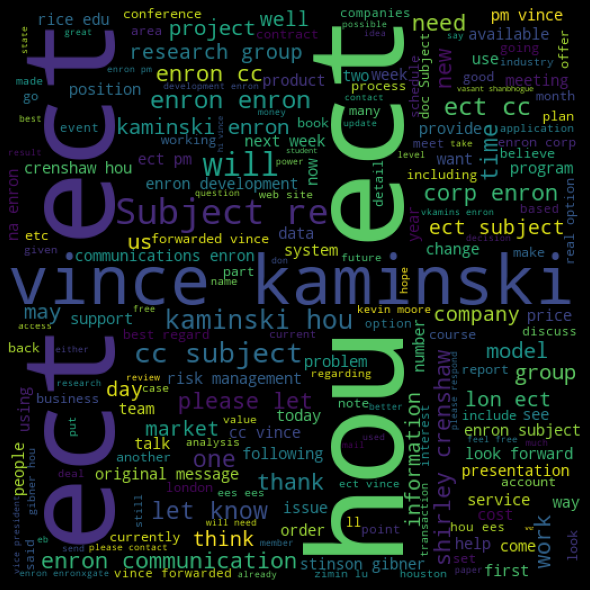

In [11]:
spam_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['text']))
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Model Training Process**

In [12]:
# assign X and y variables
X = messages_bow
y = df['spam']

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=1)

In [13]:
# get the shape of X (rows, columns)
X.shape

(5695, 37228)

## 1. **Naive-Bayes**

Why Naive-Bayes?
  1. Binary classification task.
  2. Features are independent.

Which Naive-Bayes?
  1. **Gaussian** 
    * Assumes data normality! Is our data normal?
  2. **Multinomial** 
    * Assumes data is multinomially distributed.
    * Primarily used for document classification tasks based on ***word frequency***! Relevant?
  3. **Bernoulli**
    * Similar to Multinomial, but the features are ***independent Boolean variables***.
    * For example, if a word is present is not! More suitable for our task?
  4. **Complemenent** 
    * An adaptation of the multinomial naive Bayes algorithm that is particularly suited for ***imbalanced data sets***!
  5. **Categorical/Gaussian**
    * Eror during training!

In [14]:
# select the model(s)
model_mnb = MultinomialNB()
model_ber = BernoulliNB()
model_com = ComplementNB()

# train the model
model_mnb.fit(X_train, y_train)
model_ber.fit(X_train, y_train)
model_com.fit(X_train, y_train)

ComplementNB()

## **Support Vector Machine**

**Hyperparameter Optimization using GridSearch**

GridSearchCV has four parameters:
  1. The model
  2. Param_grid: a dictionary of the parameters names and all the possible values
  3. What metric to use (default is accuracy)
  4. How many folds for k-fold cross validation (more on that at the end of this notebook!)

More info about GridSearch [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

**Hyperparameter Optimization for Support Vector Machine**:
  1. Three different **C** values: [1, 10, 100].
  2. Three different **kernels**: [linear, rbf, poly].
  3. Three different **gamma** values: [0.1, 0.5, 0.9].

More info about SVM parameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [31]:
# instantiate classifier with default parameters (kernel=rbf, C=1.0, gamma=auto)
svc = SVC()

# declare parameters for hyperparameter tuning
params = [
          {'C': [1, 10, 100], 'kernel':['linear']},
              {'C': [1, 10, 100], 'kernel': ['rbf'], 
              'gamma': [0.1, 0.5, 0.9]},
              {'C': [1, 10, 100], 'kernel': ['poly'], 'degree': [2,3,4],
               'gamma': [0.01, 0.05, 0.09]}
          ]

# create the grid search object
gs = GridSearchCV(svc, params, scoring='f1', cv=5, verbose=3)

# fit the gs object
gs.fit(X_train, y_train)

Fitting 5 folds for each of 39 candidates, totalling 195 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.975 total time=   1.9s
[CV 2/5] END ................C=1, kernel=linear;, score=0.964 total time=   1.9s
[CV 3/5] END ................C=1, kernel=linear;, score=0.963 total time=   1.9s
[CV 4/5] END ................C=1, kernel=linear;, score=0.959 total time=   1.9s
[CV 5/5] END ................C=1, kernel=linear;, score=0.981 total time=   2.0s
[CV 1/5] END ...............C=10, kernel=linear;, score=0.975 total time=   1.9s
[CV 2/5] END ...............C=10, kernel=linear;, score=0.964 total time=   1.9s
[CV 3/5] END ...............C=10, kernel=linear;, score=0.965 total time=   1.8s
[CV 4/5] END ...............C=10, kernel=linear;, score=0.961 total time=   1.9s
[CV 5/5] END ...............C=10, kernel=linear;, score=0.981 total time=   2.0s
[CV 1/5] END ..............C=100, kernel=linear;, score=0.975 total time=   2.0s
[CV 2/5] END ..............C=100, kernel=linear

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [0.1, 0.5, 0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.05, 0.09], 'kernel': ['poly']}],
             scoring='f1', verbose=3)

# **Model Evaluation**

Assess the hyperparameter optimization with GridSearch for Support Vector Machine.

In [35]:
# get the best parameters of the model
print('Parameters that give the best results:', gs.best_params_)

# get the model with the highest accuracy
print('The model with the best accucary has a score of:', (round(gs.best_score_, 4)))

# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search:', gs.best_estimator_)

# calculate GridSearch CV score on test set
print('GridSearch CV score on test set:', round(gs.score(X_test, y_test), 4))

Parameters that give the best results: {'C': 10, 'kernel': 'linear'}
The model with the best accucary has a score of: 0.9694
Estimator that was chosen by the search: SVC(C=10, kernel='linear')
GridSearch CV score on test set: 0.9817


Calculate accuracy scores with different variations of Naive-Bayes algorithm.

In [23]:
# check the prediction using Multinomial NB
print("Accuracy Score using Multinomial Naive-Bayes:\n")

# calculate accuracy score on training set
y_pred_train_mnb = model_mnb.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_mnb), 4))
# calculate accuracy score on test set
y_pred_test_mnb = model_mnb.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_mnb), 4))

# check the prediction using Bernoulli NB
print("\nAccuracy Score using Bernoulli Naive-Bayes:\n")
# calculate accuracy score on training set
y_pred_train_ber = model_ber.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_ber), 4))
# calculate accuracy score on test set
y_pred_test_ber = model_ber.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_ber), 4))

# check the prediction using Complement NB
print("\nAccuracy Score using Complement Naive-Bayes:\n")
# calculate accuracy score on training set
y_pred_train_com = model_com.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_com), 4))
# calculate accuracy score on test set
y_pred_test_com = model_com.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_com), 4))

Accuracy Score using Multinomial Naive-Bayes:

Training Set:  0.9971
Testing set:  0.9912

Accuracy Score using Bernoulli Naive-Bayes:

Training Set:  0.9917
Testing set:  0.9798

Accuracy Score using Complement Naive-Bayes:

Training Set:  0.9971
Testing set:  0.9912


* Best testing accuracy (MNB): 0.9912. 
* Compare it with the **null accuracy** (*the accuracy that could be achieved by always predicting the most frequent class*)

  * A model that predicts everything as ham on a dataset with 9,900 ham and 100 spam emails will have: (9,900 / 10,000) = **0.99 accuracy**!

In [29]:
# check class distribution in test set
print(y_test.value_counts())
# check null accuracy score
null_accuracy = round(866/(866+273), 4)
print('Null accuracy score:', null_accuracy)

0    866
1    273
Name: spam, dtype: int64
Null accuracy score: 0.7603


* Model's accuracy score (0.9912) > null accuracy score (0.7603)
* MNB classifier is doing a very good job in predicting the class labels.

In [ ]:
# print the classification report on the testing set with MNB
print("\n\t\t\tCLASSIFICATION REPORT\n\n",
      classification_report(y_test, y_pred_test_mnb))

# print the confusion matrix of the testing set with MNB
cm = confusion_matrix(y_test, y_pred_test_mnb)
print("\nCONFUSION MATRIX\n", cm)


			CLASSIFICATION REPORT

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       866
           1       0.97      0.99      0.98       273

    accuracy                           0.99      1139
   macro avg       0.98      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139


CONFUSION MATRIX
 [[858   8]
 [  2 271]]


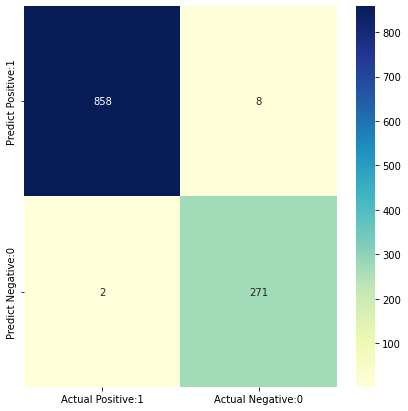

In [ ]:
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

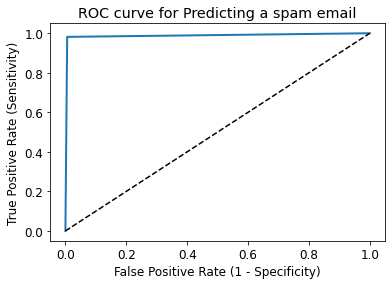

ROC AUC : 0.9880
Cross validated ROC AUC : 0.9972


In [ ]:
# plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_svm)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a spam email')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

# compute ROC AUC
ROC_AUC = roc_auc_score(y_test, y_pred_test_svm)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

# calculate cross-validated ROC AUC
Cross_validated_ROC_AUC = cross_val_score(model_svm, X_train, y_train, cv=10,
                                          scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

# **K-Fold Cross-Validation**

**K-fold cross-validation** is a very useful technique to evaluate model 
performance. Instead of doing a single training-test split, we split our dataset multiple times.

The reasons behind K-Fold are:
  1. A certain split selected randomly at the start (*random_state=10*) may not be optimal. 
  2. The test set generated from that split is never used to evaluate the model.

But, ***it fails here because we have a imbalanced dataset***. 
So, in the case of imbalanced dataset, I will use another technique to 
evaluate model performance. It is called **stratified k-fold cross-validation**.

In stratified k-fold cross-validation, we split the data such that the proportions between classes are the same in each fold as they are in the whole dataset.

In [ ]:
# choose how many train/test sets we want by "n_splits"
kfold = KFold(n_splits=5, shuffle=True)
# reminder that we are using a SVM model with linear kernel
model_svm = SVC(kernel='linear')
# calculate the accuracy score of each of the 5 train/test sets
svm_scores = cross_val_score(model_svm, X, y, cv=kfold)
# print cross-validation scores with SVM linear kernel
print('Stratified cross-validation scores with SVM (linear kernel):\n',
      (svm_scores))
# print average cross-validation score with linear kernel
print('\nAverage stratified cross-validation score with SVM (linear kernel):',
      round(svm_scores.mean(), 4))

Stratified cross-validation scores with SVM (linear kernel):
 [0.98770852 0.98419666 0.98244074 0.98595259 0.98068481]

Average stratified cross-validation score with SVM (linear kernel): 0.9842


Our original model test accuracy is 0.9832 while GridSearch CV score on 
test-set is 0.9835. So, GridSearch CV helps to identify the parameters that will improve the performance for this particular model.

Here, we should not confuse best_score_ attribute of grid_search with the 
score method on the test-set. The score method on the test-set gives the generalization performance of the model. Using the score method, we employ a model trained on the whole training set. The best_score_ attribute gives the mean cross-validation accuracy, with cross-validation performed on the training set.

# Results and Conclusions

We get maximum accuracy with rbf and linear kernel with C=100.0 and the 
accuracy is 0.9832. So, we can conclude that our model is doing a very good 
job in terms of predicting the class labels. 

But, this is not true! Here, we have an ***imbalanced dataset***. Accuracy is an inadequate measure for quantifying predictive performance in the imbalanced dataset problem. So, we must explore confusion matrix that provide better guidance in selecting models.

***ROC AUC of our model is very close to 1***. So, we can conclude that our 
classifier does a good job in classifying the spam emails.

I obtain higher average stratified k-fold cross-validation score of 0.9789 
with linear kernel but the model accuracy is 0.9832. So, stratified cross-validation technique does not help to improve the model performance.

Our original model test accuracy is 0.9832 while GridSearch CV score on
test-set is 0.9835. So, GridSearch CV helps to identify the parameters 
that will improve the performance for this particular model.